In [33]:
import numpy as np
from pathlib import Path

from monai.transforms import (
    Compose,
    LoadImaged,
    AddChanneld,
    Resized,
    ScaleIntensityRanged,
)

def extract_3d_roi(
    segmentation_path, destination_path, eventual_roi_size=100, save_size=96
):
    pipeline = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            AddChanneld(keys=["img", "seg"]),
            FindCentroid(),
            GetFixedROISize(eventual_roi_size),
            Pad(),
            CropToROI(),
            Resized(keys=["img"], spatial_size=[int(save_size * np.sqrt(2))] * 3),
            ScaleIntensityRanged(
                keys=["img"], a_min=-1024, a_max=3000, b_min=0, b_max=1, clip=True
            ),
            Save(output_dir=destination_path),
        ]
    )

    segmentation_path = Path(segmentation_path)
    scan_path = find_corresponding_scan(segmentation_path)
    data = {"img": str(scan_path), "seg": str(segmentation_path)}

    pipeline(data)


def preprocess_dir(segmentation_dir, destination_dir):
    pass


def find_corresponding_scan(segmention_path):
    scan_folder = segmention_path.parent.parent / "scans"
    scan_name = segmention_path.name.split(".")[0][:-2] + ".nii.gz"

    return scan_folder / scan_name


extract_3d_roi(
    r"D:\premium_data\amphia\monotherapy\split_segmentations",
    r"C:\Users\user\data\dl_radiomics\preprocessed_3d",
)


RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x000001F1D343B9A0>

In [1]:

r = Path(r'D:/premium_data/')
centers = [
    'amphia',
    'isala',
    'lumc',
    'maxima',
    'mst',
    'radboud',
    'umcu',
    'vumc',
    'zuyderland'
]

path = r / centers[0] / 'monotherapy' / 'split_segmentations'
segmentation = list(path.iterdir())[0]

In [2]:
# https://github.com/Project-MONAI/tutorials/blob/main/modules/3d_image_transforms.ipynb


def extract_3d_roi(scan_path, segmentation_path, destination_path, roi_size):
    pass


def preprocess_dir(scan_dir, segmentation_dir, destination_dir):
    pass


def find_corresponding_scan(segmention_path):
    scan_folder = segmentation.parent.parent / 'scans'
    scan_name = segmentation.name.split('.')[0][:-2] + '.nii.gz'

    return scan_folder / scan_name

In [3]:
scan = find_corresponding_scan(segmentation)

In [31]:
import numpy as np
from monai.transforms import (
    Compose,
    LoadImaged,
    Transform,
    SpatialCrop,
    BorderPad,
    AddChanneld,
    Resized,
    ScaleIntensityRanged,
    SaveImage
)

class FindCentroid(Transform):
    def __call__(self, data):
        seg = data['seg']
        centroid = [int(np.mean(coor)) for coor in np.where(seg)][1:]
        data['centroid'] = centroid
        return data

class GetFixedROISize(Transform):
    def __init__(self, eventual_size=100):
        super().__init__()
        self.size = eventual_size * np.sqrt(2)

    def __call__(self, data):
        assert (data['img'].affine == data['seg'].affine).all()

        roi_size = (self.size / data['img'].affine.diag()[:-1]).int()
        data['roi_size'] = np.array(roi_size)

        return data

class Pad(Transform):
    def __call__(self, data):
        border_size = (np.ceil(data['roi_size'] / 2)).astype(int).tolist()
        padder = BorderPad(border_size, value=-1024)
        data['img'] = padder(data['img'])
        data['centroid'] += np.array(border_size)
        return data

class CropToROI(Transform):
    def __call__(self, data):
        cropper = SpatialCrop(
            roi_center=data['centroid'],
            roi_size=data['roi_size']
        )
        data['img'] = cropper(data['img'])
        data['img'].meta['spatial_shape'] = np.array(data['img'].shape[1:])
        data['img'].meta['affine'] = data['img'].meta['affine'] * np.eye(4)
        return data

class Save(Transform):
    def __init__(self, output_dir):
        super().__init__()
        self.output_dir = output_dir

    def __call__(self, data):
        postfix = Path(data['seg'].meta['filename_or_obj']).name.split('.')[0][-1:]
        saver = SaveImage(
            output_dir=self.output_dir,
            output_postfix=postfix,
            separate_folder=False
        )
        saver(data['img'])

        return data


data = {'img':str(scan), 'seg':str(segmentation)}

eventual_roi_size = 100
save_size = 96

preprocess = Compose([
    LoadImaged(keys=['img','seg']),
    AddChanneld(keys=['img','seg']),
    FindCentroid(),
    GetFixedROISize(eventual_roi_size),
    Pad(),
    CropToROI(),
    Resized(keys=['img'], spatial_size=[int(save_size*np.sqrt(2))]*3),
    ScaleIntensityRanged(keys=['img'], a_min=-1024, a_max=3000, b_min=0, b_max=1, clip=True),
    Save(output_dir = r'C:\Users\user\data\dl_radiomics\preprocessed_3d')
])

output = preprocess(data)



    

c:\Users\user\anaconda3\envs\rob\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


2022-10-25 13:19:58,379 INFO image_writer.py:193 - writing: C:\Users\user\data\dl_radiomics\preprocessed_3d\PREM_AM_001_0.nii.gz


In [27]:
output['img'].meta

{'sizeof_hdr': array(348),
 'extents': array(0),
 'session_error': array(0, dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'dim': array([  3, 512, 512, 263,   1,   1,   1,   1], dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'intent_code': array(0, dtype=int16),
 'datatype': array(4, dtype=int16),
 'bitpix': array(16, dtype=int16),
 'slice_start': array(0, dtype=int16),
 'pixdim': array([1.       , 0.7324219, 0.7324219, 3.       , 1.       , 1.       ,
        1.       , 1.       ], dtype=float32),
 'vox_offset': array(0., dtype=float32),
 'scl_slope': array(nan, dtype=float32),
 'scl_inter': array(nan, dtype=float32),
 'slice_end': array(0, dtype=int16),
 'slice_code': array(0, dtype=uint8),
 'xyzt_units': array(0, dtype=uint8),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'slice_duration': array(0., dtype=float32),
 'toffset': array(0., dtype=float32),
 'glmax':

array([96, 96, 96])

In [6]:
CropToROI()(output)

RuntimeError: The size of tensor a (6) must match the size of tensor b (3) at non-singleton dimension 0

In [203]:
output['img'].shape

(1, 193, 167, 47)

In [206]:
output['img'].shape

(1, 96, 96, 96)

In [208]:
output['centroid'] += [5,5,5]

(array([3.80351e+05, 4.92497e+05, 9.08200e+03, 1.28800e+03, 7.34000e+02,
        4.20000e+02, 2.14000e+02, 9.10000e+01, 3.70000e+01, 2.20000e+01]),
 array([0.20902362, 0.24758668, 0.28614974, 0.32471281, 0.36327589,
        0.40183896, 0.440402  , 0.47896507, 0.51752812, 0.55609119,
        0.59465426]),
 <BarContainer object of 10 artists>)

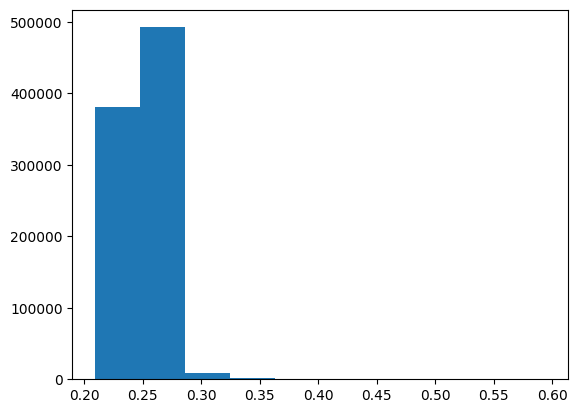

In [184]:
import matplotlib.pyplot as plt

plt.hist(output['img'].flatten())

In [179]:
pip install matplotlib


     ---------------------------------------- 7.2/7.2 MB 32.9 MB/s eta 0:00:00
     ------------------------------------- 965.4/965.4 kB 15.4 MB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 23.3 MB/s eta 0:00:00
     ---------------------------------------- 55.3/55.3 kB 1.5 MB/s eta 0:00:00
     -------------------------------------- 164.1/164.1 kB 3.3 MB/s eta 0:00:00


In [111]:
output['img'].shape

(512, 512, 263)

In [101]:
new_size

array([705, 705, 310])

array([193, 193,  47])